In [2]:
import gzip
import sys
import os
import json
import math
import calendar
import codecs
import datetime
import scipy.stats
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from textblob import TextBlob
from scipy.stats import linregress

In [9]:
eventCredFile = "annotatedEvents_credibility.json"

eventMap = {}

likertScale = range(-2,3)

with open(eventCredFile, "r") as credFile:
    for line in credFile:
        event = json.loads(line)
        
        eventKey = event["key"]
        eventMean = event["mean"]
        eventRatings = np.array(event["ratings"])
        
        count = float(len(eventRatings))
        
        # Normalize vote counts and find the largest vote
        scaleCounts = [np.argwhere(eventRatings == x).shape[0] for x in likertScale]
        scalePercents = map(lambda x: float(x) / count, scaleCounts)
        maxAgreement = max(scalePercents)
        majorityVoteIndex = np.argwhere(np.array(scalePercents) == maxAgreement)[0]
        
        # Account for ties
        majorityVote = None
        if ( majorityVoteIndex.shape[0] == 1 ):
            majorityVote = likertScale[majorityVoteIndex]
        else:
            voteSum = 0.0
            for i in majorityVoteIndex:
                voteSum += likertScale[i]
            majorityVote = voteSum / majorityVoteIndex.shape[0]
        

        
        # Simple majority vote between positive and negative is not adequate
        #  since only one event has a majority below zero.
#         posCount = len(filter(lambda x: x>0, eventRatings))
#         negCount = len(filter(lambda x: x<0, eventRatings))

        # Instead, we treat only events with majority "Certainly Accurate" as
        #  candidates for positive samples
        posCount = len(filter(lambda x: x==2, eventRatings))
        negCount = count - posCount
        
        # Majority vote
        eventVote = 0
#         if ( negCount > posCount ):
#             eventVote = -1
#         elif ( posCount > negCount ):
#             eventVote = 1
        if ( eventMean > 1.95 ):
            eventVote = 1
        elif ( eventMean < 1.2 ):
            eventVote = -1
            
        # Thresholding. Treat as positive if many votes are "Certain, Accurate"
        eventVoteThresh = 0
        if ( posCount >= count * 0.95 ):
            eventVoteThresh = 1
        elif ( posCount >= count * 0.5 ):
            eventVoteThresh = 0
        else:
            eventVoteThresh = -1
            
        # TODO: Remove this assignment. Used for quick and dirty update
        eventVoteThresh = eventVote
        
        if ( eventVoteThresh < 0 ):
            print majorityVote, eventVote, eventKey
            
            
        # Find the most agreed-upon label
        eventAgreedVote = 0
        if ( maxAgreement >= 0.7 ):
            if ( majorityVote < 0 ):
                eventAgreedVote = -1
            elif ( majorityVote > 0 ):
                eventAgreedVote = 1
        
        eventMap[eventKey] = (eventMean, eventVote, eventVoteThresh, eventAgreedVote, majorityVote)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:26: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


1 -1 october_ebola_house-20141015_230140-20141016_000502
2 -1 oscar_pistorius_because-20141016_044421-20141016_060856
2 -1 ebola_obama_#ebola-20141016_181953-20141016_192544
2 -1 year_artist_#amas-20141016_203448-20141016_213927
2 -1 #oscartrial_roux_him-20141017_021821-20141017_040749
2 -1 ebola_obama_said-20141017_081818-20141017_092258
2 -1 news_breaking_ebola-20141017_123802-20141017_134846
2 -1 retweet_year_#amas-20141019_065743-20141019_081304
2 -1 year_artist_#amas-20141019_065743-20141019_081304
2 -1 man_liverpool_qpr-20141019_091953-20141019_102237
2 -1 god_thank_ebola-20141020_075900-20141020_090750
2 -1 ebola_free_sometimes-20141020_101221-20141020_111325
2 -1 news_breaking_ebola-20141022_095002-20141022_104357
2 -1 watch_trailer_teaser-20141022_213926-20141022_224704
2 -1 artist_#amas_favorite-20141023_225011-20141024_001313
2 -1 tonight_rivers_believe-20141023_225011-20141024_001313
2 -1 louis_ebola_nurse-20141024_170629-20141024_181626
2 -1 ebola_news_check-20141025_07450

[  0.00000000e+00   7.26216412e-04   2.25127088e-02   9.76761075e-01] [-2 -1  0  1  2]


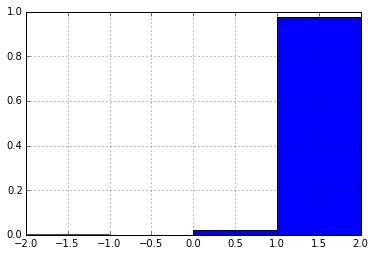

[ 0.          0.0486565   0.87944808  0.07189542] [-2 -1  0  1  2]


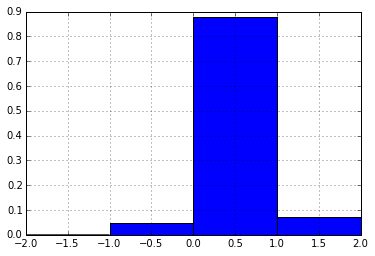

[ 0.          0.0486565   0.87944808  0.07189542] [-2 -1  0  1  2]


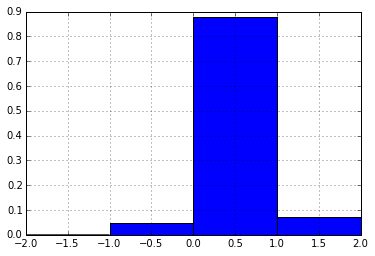

[ 0.          0.          0.18300654  0.81699346] [-2 -1  0  1  2]


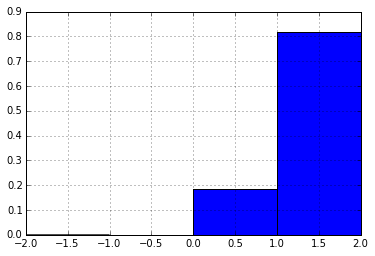

[  7.26216412e-04   0.00000000e+00   1.45243282e-03   9.97821351e-01] [-2 -1  0  1  2]


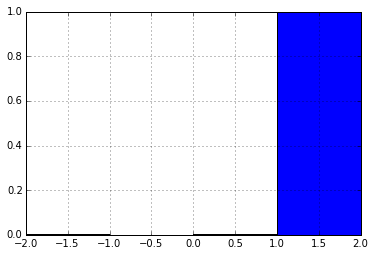

In [10]:
for i in range(5):
    xData = map(lambda x: x[i], eventMap.values())
    (n, b, _) = plt.hist(xData, normed=True, align='mid', bins=[-2,-1,0,1,2])
    print n, b
    plt.grid(which='major')
#     plt.ylim((0, 1))
    plt.show()

In [11]:
votes = map(lambda x: x[0], eventMap.values())
for v in [-3, -2, -1, 0, 1]:
    voteCount = len(filter(lambda x: x>v and x <=v+1, votes))
    print "(%d, %d]" % (v, v+1), "Vote Count:", voteCount

(-3, -2] Vote Count: 0
(-2, -1] Vote Count: 0
(-1, 0] Vote Count: 1
(0, 1] Vote Count: 34
(1, 2] Vote Count: 1342


In [12]:
count = float(len(eventMap.values()))
votes = map(lambda x: x[1], eventMap.values())
for v in [-1, 0, 1]:
    voteCount = len(filter(lambda x: x==v, votes))
    print "%d" % (v), "Vote Count:", voteCount, ", %:", voteCount/count

-1 Vote Count: 67 , %: 0.0486564996369
0 Vote Count: 1211 , %: 0.879448075527
1 Vote Count: 99 , %: 0.0718954248366


In [13]:
count = float(len(eventMap.values()))
votes = map(lambda x: x[2], eventMap.values())
for v in [-1, 0, 1]:
    voteCount = len(filter(lambda x: x==v, votes))
    print "%d" % (v), "Vote Count:", voteCount, ", %:", voteCount/count

-1 Vote Count: 67 , %: 0.0486564996369
0 Vote Count: 1211 , %: 0.879448075527
1 Vote Count: 99 , %: 0.0718954248366


In [14]:
count = float(len(eventMap.values()))
votes = map(lambda x: x[3], eventMap.values())
for v in [-1, 0, 1]:
    voteCount = len(filter(lambda x: x==v, votes))
    print "%d" % (v), "Vote Count:", voteCount, ", %:", voteCount/count

-1 Vote Count: 0 , %: 0.0
0 Vote Count: 252 , %: 0.183006535948
1 Vote Count: 1125 , %: 0.816993464052


In [15]:
for (event, ratings) in eventMap.items():
    if ( ratings[2] == -1 ):
        print event, ratings

year_city_liverpool-20141231_071741-20141231_081731 (1.1333333333333333, -1, -1, 0, 2)
joshane_event_give-20141214_235644-20141215_010737 (0.9333333333333333, -1, -1, 0, 1)
killed_hostage_isis-20150206_144013-20150206_155447 (0.6333333333333333, -1, -1, 0, 0)
ebola_west_obama-20141017_102419-20141017_112645-20141017_113249 (0.8, -1, -1, 0, 2)
kim_park_winner-20141027_042412-20141027_055036 (1.0666666666666667, -1, -1, 0, 2)
god_thank_ebola-20141020_075900-20141020_090750 (0.9333333333333333, -1, -1, 0, 2)
#oscartrial_roux_him-20141017_021821-20141017_040749 (1.1666666666666667, -1, -1, 0, 2)
next_coach_michigan-20141217_174901-20141217_191126 (0.9333333333333333, -1, -1, 0, 1)
cowboys_game_fans-20150111_144629-20150111_155923 (1.1, -1, -1, 0, 2)
watch_trailer_teaser-20141022_213926-20141022_224704 (1.1666666666666667, -1, -1, 0, 2)
isis_hostage_killed-20150206_121857-20150206_132848 (0.9666666666666667, -1, -1, 0, 2)
man_liverpool_qpr-20141019_091953-20141019_102237 (1.1, -1, -1, 0, 2)

In [16]:
credibleFile = open("credible_collapse.txt", "w")
incredibleFile = open("incredible_collapse.txt", "w")

posList = []
negList = []

eventCountMap = {}

for (event, ratings) in eventMap.items():
    eventFile = "singleFileEventData_entityCollapse/%s.txt" % event
    eventCountMap[event] = 0
    
    outputDest = None
    if ( ratings[2] == -1 ):
        outputDest = incredibleFile
        negList.append(event)
    elif ratings[2] == 1:
        outputDest = credibleFile
        posList.append(event)
        
    if ( outputDest is not None ):
        with open(eventFile, "r") as evf:
            for line in evf:
                outputDest.write(line)
                eventCountMap[event] += 1
            
credibleFile.close()
incredibleFile.close()

In [17]:
posCountList = [eventCountMap[x] for x in posList]
negCountList = [eventCountMap[x] for x in negList]
posCount = np.sum(posCountList)
negCount = np.sum(negCountList)
posAvg = np.mean(posCountList)
negAvg = np.mean(negCountList)

print "Pos Count:", posCount, "Avg:", posAvg
print "Neg Count:", negCount, "Avg:", negAvg

Pos Count: 75874 Avg: 766.404040404
Neg Count: 47374 Avg: 707.074626866


## Find density per event

In [18]:
oldEventMap = eventMap

In [19]:
means = map(lambda x: x[0], oldEventMap.values())
print "Average Rating:", np.mean(means)
print "Rating Sigma:", np.std(means)

Average Rating: 1.7015166826
Rating Sigma: 0.252968971001


In [20]:
def extendTimes(timeMap):
#     sortedTimes = sorted(timeMap.keys())
#     startTime = sortedTimes[0]
#     endTime = sortedTimes[-1]
#     currentTime = startTime
#     timeStep = datetime.timedelta(hours=1)
    
#     while(currentTime < endTime):
#         currentTime = currentTime + timeStep
#         if ( currentTime not in sortedTimes ):
#             timeMap[currentTime] = []
    
    return timeMap

def makeCounts(tweets):
    retweetCount = 0
    urlCount = 0
    mediaCount = 0
    mentionCount = 0
    hashtagCount = 0
    tweetCount = 0
    
    for tweet in tweets:
        if ( "retweeted_status" in tweet ):
            retweetCount += 1
            continue
            
        entityFlag = False
        
        entityList = tweet["entities"]
        if (len(entityList["user_mentions"]) > 0):
            mentionCount += 1
            entityFlag = True
        if (len(entityList["hashtags"]) > 0):
            hashtagCount += 1
            entityFlag = True
        if (len(entityList["urls"]) > 0):
            urlCount += 1
            entityFlag = True
        if ( "media" in entityList ):
            mediaCount += 1
            entityFlag = True
            
        if ( not entityFlag ):
            tweetCount += 1
           
    countMap = {
        "retweetCount": retweetCount,
        "urlCount": urlCount,
        "mediaCount": mediaCount,
        "hashtagCount": hashtagCount,
        "mentionCount": mentionCount,
        "tweetCount": tweetCount
    }
    
    return countMap

In [21]:

threadDir = "singleFileEventData"

# timeReset = {'second': 0, 'minute': 0}
timeReset = {'second': 0}
timeFormat = "%a %b %d %H:%M:%S +0000 %Y"

eventMap = {}

for (eventKey, ratings) in oldEventMap.items():

    truthValue = None
    if ( ratings[2] == -1 ):
        print "Negative:", eventKey
        truthValue = 0
    elif ratings[2] == 1:
        #print "Positive:", eventKey
        truthValue = 1
        
    if ( truthValue is None ):
        continue

    tweetPath = "%s%s%s" % (threadDir, os.sep, eventKey) + ".json.gz"
    tweetDateMap = {}

    with gzip.open(tweetPath, "rb") as tweetFile:

        for line in tweetFile:
            tweet = json.loads(line.decode("utf8"))

            # Deleted status messages and protected status must be skipped
            if ( "delete" in tweet.keys() or "status_withheld" in tweet.keys() ):
                continue

            # Try to extract the time of the tweet
            try:
                currentTime = datetime.datetime.strptime(tweet['created_at'], timeFormat)
            except:
                print (line)
                raise

            currentTime = currentTime.replace(**timeReset)

            if ( currentTime in tweetDateMap ):
                tweetDateMap[currentTime].append(tweet)
            else:
                tweetDateMap[currentTime] = [tweet]
        
    if ( len(tweetDateMap) == 0 ):
        continue
        
    # fill out the date map
    tweetDateMap = extendTimes(tweetDateMap)
    
    fullTweetList = [tweet for tl in tweetDateMap.values() for tweet in tl]
    countMap = makeCounts(fullTweetList)

#         print eventKey, len(tweetDateMap.keys())
    eventMap[eventKey] = {
        "truth": truthValue, 
        "tweets": tweetDateMap,
        "retweetCount": countMap["retweetCount"],
        "urlCount": countMap["urlCount"],
        "mediaCount": countMap["mediaCount"],
        "hashtagCount": countMap["hashtagCount"],
        "mentionCount": countMap["mentionCount"],
        "tweetCount": countMap["tweetCount"],
    }
    

# eventMap[eventKey] = (eventMean, eventVote, eventVoteThresh, eventAgreedVote)

Negative: year_city_liverpool-20141231_071741-20141231_081731
Negative: joshane_event_give-20141214_235644-20141215_010737
Negative: killed_hostage_isis-20150206_144013-20150206_155447
Negative: ebola_west_obama-20141017_102419-20141017_112645-20141017_113249
Negative: kim_park_winner-20141027_042412-20141027_055036
Negative: god_thank_ebola-20141020_075900-20141020_090750
Negative: #oscartrial_roux_him-20141017_021821-20141017_040749
Negative: next_coach_michigan-20141217_174901-20141217_191126
Negative: cowboys_game_fans-20150111_144629-20150111_155923
Negative: watch_trailer_teaser-20141022_213926-20141022_224704
Negative: isis_hostage_killed-20150206_121857-20150206_132848
Negative: man_liverpool_qpr-20141019_091953-20141019_102237
Negative: cops_black_police-20141221_102623-20141221_112747
Negative: kobe_dwight_nigga-20141029_022108-20141029_040700
Negative: osu_stop_bama-20150101_233743-20150102_004727
Negative: grammys_watch_away-20150208_204025-20150208_213235
Negative: bobby_w

In [22]:
dl = eventMap["joshane_event_give-20141214_235644-20141215_010737"]
sortedTimes = sorted(dl["tweets"].keys())
print sortedTimes[0], sortedTimes[1]
print "Times:", len(dl)

2014-12-14 16:07:00 2014-12-14 16:09:00
Times: 8


In [23]:
for eventKey in eventMap.keys():
    localG = nx.Graph()
    dl = eventMap[eventKey]
    
    densityMap = {}
    sentMap = {}
    objMap = {}

    sentimentList = []
    objectivityList = []
    
    for sliceTime in sorted(dl["tweets"].keys()):
        tweetList = dl["tweets"][sliceTime]
        if ( len(tweetList) == 0 ):
            continue
            
        for tweet in tweetList:
            textBlob = TextBlob(tweet["text"])
            sentiment = textBlob.sentiment
            
            sentimentList.append(sentiment.polarity)
            objectivityList.append(sentiment.subjectivity)
            
            tweetingUser = tweet["user"]["name"]
            localG.add_node(tweetingUser)
            
            mentions = [mentionedUser["screen_name"] for mentionedUser in tweet["entities"]["user_mentions"]]
            edges = map(lambda x: (tweetingUser, x), mentions)

            localG.add_edges_from(edges)

        if ( len(nx.edges(localG)) > 0 ):
            localDensity = nx.density(localG)
            densityMap[sliceTime] = localDensity
            
        sentMap[sliceTime] = np.array(sentimentList).mean()
        objMap[sliceTime] = np.array(objectivityList).mean()

#         densityMap[sliceTime] = len([x for x in nx.connected_components(localG)])
        
    dl["polarity"] = sentMap
    dl["objectivity"] = objMap
    dl["density"] = densityMap

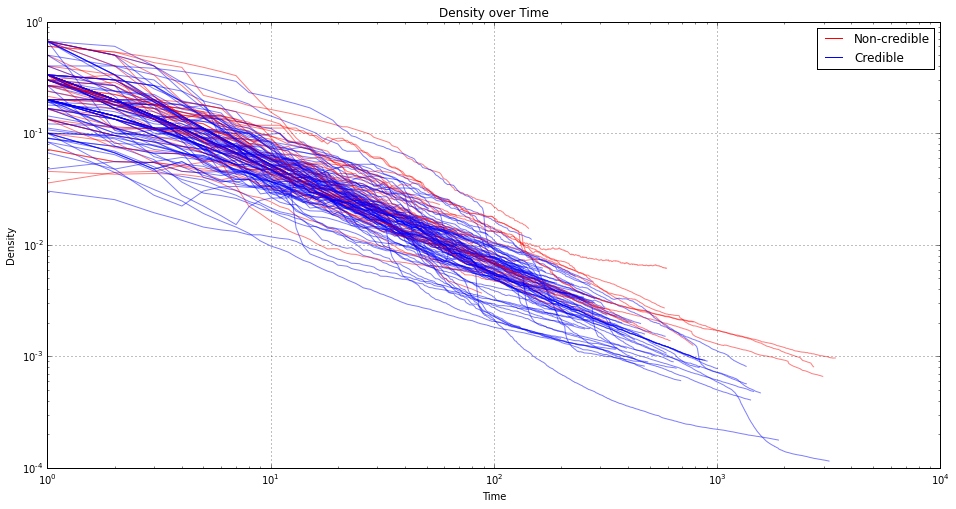

bad count: 0
True Avg: 0.0095326457834
False Avg: 0.100624442044


In [24]:
plt.figure(figsize=(16,8))

trueData = []
falseData = []

badDataCount = 0

for eventKey in eventMap.keys():
    localEvent = eventMap[eventKey]
    densityMap = localEvent["density"]
    sortedTimes = sorted(densityMap.keys())
    xData = range(len(sortedTimes))
#     yData = map(lambda x: (1.0 / densityMap[x]), sortedTimes)
    yData = map(lambda x: densityMap[x], sortedTimes)
    
    if ( len(yData) == 0 ):
        badDataCount+=1
        continue
    
    if ( localEvent["truth"] == 0 ):
        plt.loglog (xData, yData, color="r", alpha=0.5)
        falseData.append(np.median(yData))
    elif ( localEvent["truth"] == 1 ):
        plt.loglog (xData, yData, color="b", alpha=0.5)
        trueData.append(np.median(yData))

plt.loglog([0], [0], color="r", label="Non-credible")
plt.loglog([0], [0], color="b", label="Credible")
plt.xlabel("Time")
plt.ylabel("Density")

plt.title("Density over Time")
plt.legend()
plt.grid()
plt.show()

print "bad count:", badDataCount
print "True Avg:", np.mean(trueData)
print "False Avg:", np.mean(falseData)

In [25]:
tResStat, tPVal = scipy.stats.ttest_ind(trueData, falseData)

print "T-Test Statistic:", tResStat
print "p-Value:", tPVal

T-Test Statistic: -4.37062133727
p-Value: 2.26847609015e-05


## Polarity and Subjectivity

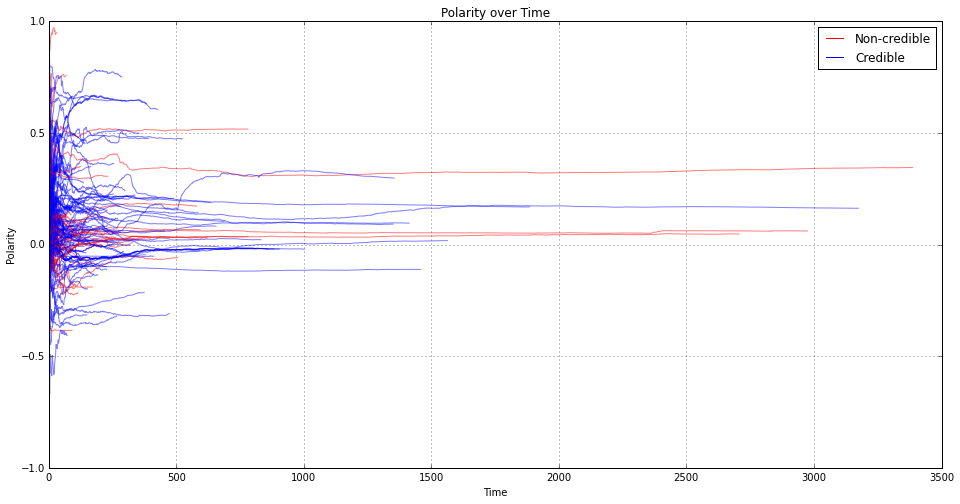

bad count: 0
True Avg: 0.117657405747
False Avg: 0.102820370824
T-Test Statistic: 0.378502099889
p-Value: 0.705578908301


In [26]:
plt.figure(figsize=(16,8))

trueData = []
falseData = []

badDataCount = 0 

for eventKey in eventMap.keys():
    localEvent = eventMap[eventKey]
    sentMap = localEvent["polarity"]
    sortedTimes = sorted(sentMap.keys())
    xData = range(len(sortedTimes))
#     yData = map(lambda x: (1.0 / densityMap[x]), sortedTimes)
    yData = map(lambda x: sentMap[x], sortedTimes)
    
    if ( len(yData) == 0 ):
        badDataCount+=1
        continue
    
    if ( localEvent["truth"] == 0 ):
        plt.plot (xData, yData, color="r", alpha=0.5)
        falseData.append(np.median(yData))
    elif ( localEvent["truth"] == 1 ):
        plt.plot (xData, yData, color="b", alpha=0.5)
        trueData.append(np.median(yData))

plt.plot([0], [0], color="r", label="Non-credible")
plt.plot([0], [0], color="b", label="Credible")
plt.xlabel("Time")
plt.ylabel("Polarity")
plt.legend()

plt.title("Polarity over Time")
plt.grid()
plt.show()

print "bad count:", badDataCount
print "True Avg:", np.mean(trueData)
print "False Avg:", np.mean(falseData)

tResStat, tPVal = scipy.stats.ttest_ind(trueData, falseData)

print "T-Test Statistic:", tResStat
print "p-Value:", tPVal

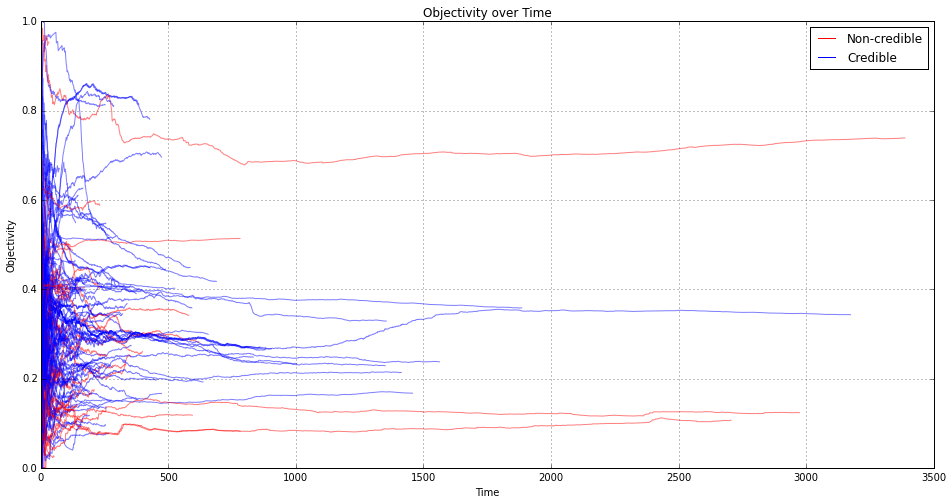

True Avg: 0.347415681286
False Avg: 0.324149706093
T-Test Statistic: 0.790946577473
p-Value: 0.430191584908


In [27]:
plt.figure(figsize=(16,8))

trueData = []
falseData = []

for eventKey in eventMap.keys():
    localEvent = eventMap[eventKey]
    objMap = localEvent["objectivity"]
    sortedTimes = sorted(objMap.keys())
    xData = range(len(sortedTimes))
#     yData = map(lambda x: (1.0 / densityMap[x]), sortedTimes)
    yData = map(lambda x: objMap[x], sortedTimes)
    
    if ( localEvent["truth"] == 0 ):
        plt.plot (xData, yData, color="r", alpha=0.5)
        falseData.append(np.median(yData))
    elif ( localEvent["truth"] == 1 ):
        plt.plot (xData, yData, color="b", alpha=0.5)
        trueData.append(np.median(yData))
    
plt.plot([0], [0], color="r", label="Non-credible")
plt.plot([0], [0], color="b", label="Credible")
plt.xlabel("Time")
plt.ylabel("Objectivity")
plt.legend()

plt.title("Objectivity over Time")
plt.grid()
plt.show()

# 0 is very objective, 1 is very subjective
print "True Avg:", np.mean(trueData)
print "False Avg:", np.mean(falseData)

tResStat, tPVal = scipy.stats.ttest_ind(trueData, falseData)

print "T-Test Statistic:", tResStat
print "p-Value:", tPVal

## Account age

In [28]:
for eventKey in eventMap.keys():
    dl = eventMap[eventKey]
    
    sliceAgeMap = {}
    
    sortedTimes = sorted(dl["tweets"].keys())
    
    if ( len(sortedTimes) == 0 ):
        print eventKey, "zero entries"
    windowSize = 1
    
    accountAges = []
    
    for i in range(0, max(1, len(sortedTimes) - windowSize)):

        
        window = sortedTimes[i:i+windowSize]
        
        for sliceTime in window:
            tweetList = dl["tweets"][sliceTime]
            if ( len(tweetList) == 0 ):
                continue

            for tweet in tweetList:
                tweetCreatedTime = datetime.datetime.strptime(tweet["created_at"], timeFormat)
                userCreatedTime = datetime.datetime.strptime(tweet["user"]["created_at"], timeFormat)
                timeDif = tweetCreatedTime - userCreatedTime

                accountAges.append(timeDif.total_seconds())
            
        averageAge = np.mean(accountAges)
        
        if ( math.isnan(averageAge) ):
            print window, accountAges
        sliceAgeMap[window[0]] = averageAge

    dl["ages"] = sliceAgeMap
            

/Library/Python/2.7/site-packages/scipy/stats/stats.py:3069: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1-r*r)*ssym / ssxm / df)


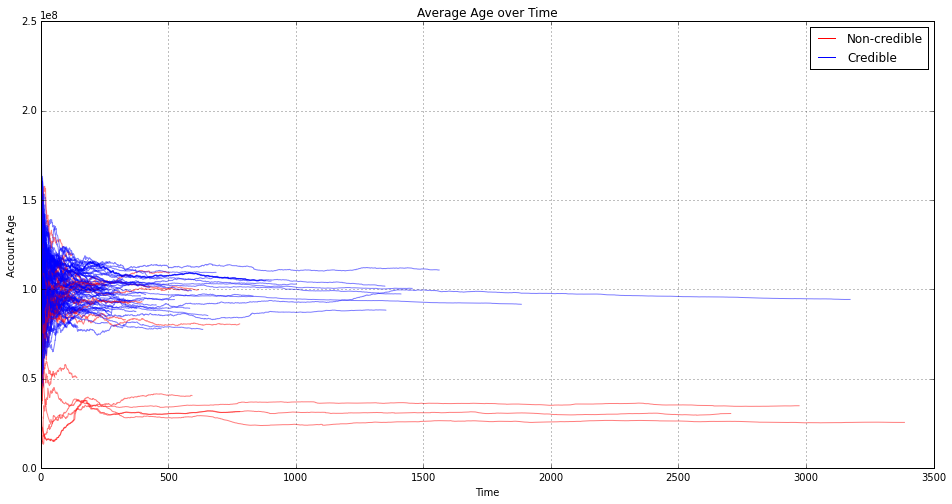

True Avg: -137239.326495
False Avg: -327124.865492
T-Test Statistic: 0.223471549335
p-Value: 0.82347056713


In [29]:
plt.figure(figsize=(16,8))

trueData = []
falseData = []

for eventKey in eventMap.keys():
    localEvent = eventMap[eventKey]
    ageMap = localEvent["ages"]
    sortedTimes = sorted(ageMap.keys())
    
    if ( len(sortedTimes) <= 1 ):
        continue
        
    xData = range(len(sortedTimes))
    yData = map(lambda x: ageMap[x], sortedTimes)
    
    (m, b, r, p, err) = linregress(xData, yData)
    
    if ( localEvent["truth"] == 0 ):
        plt.plot (xData, yData, color="r", alpha=0.5)
#         plt.plot(xData, map(lambda x: m*x + b, xData), color="r", alpha=0.5)
        falseData.append(m)
    elif ( localEvent["truth"] == 1 ):
        plt.plot (xData, yData, color="b", alpha=0.5)
#         plt.plot(xData, map(lambda x: m*x + b, xData), color="b", alpha=0.5)
        trueData.append(m)
    
plt.plot([0], [0], color="r", label="Non-credible")
plt.plot([0], [0], color="b", label="Credible")
plt.xlabel("Time")
plt.ylabel("Account Age")
plt.legend()

plt.title("Average Age over Time")
plt.grid()
plt.show()

# 0 is very objective, 1 is very subjective
print "True Avg:", np.mean(trueData)
print "False Avg:", np.mean(falseData)

tResStat, tPVal = scipy.stats.ttest_ind(trueData, falseData)

print "T-Test Statistic:", tResStat
print "p-Value:", tPVal

## Day count

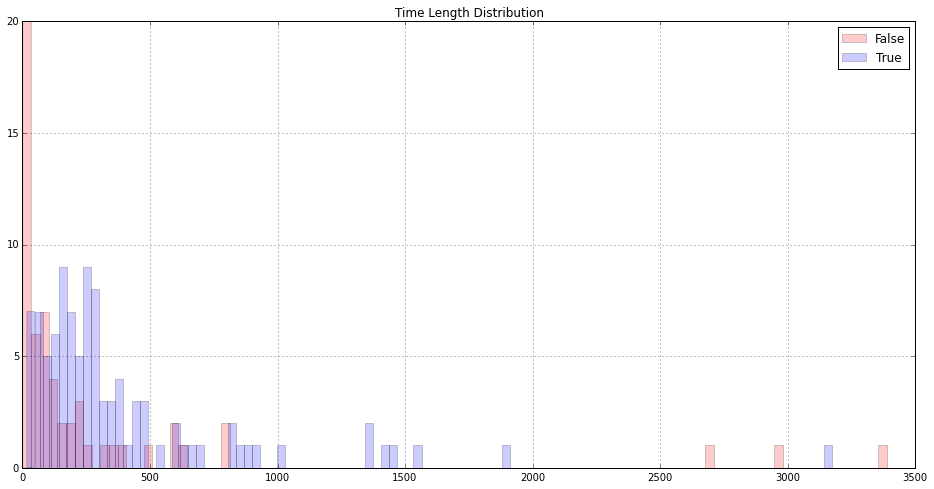

True Count: 99
True Avg: 386.494949495
True Med: 255.0
False Count: 57
False Avg: 301.035087719
False Med: 81.0
T-Test Statistic: 0.932269640957
p-Value: 0.352656475241


In [30]:
plt.figure(figsize=(16,8))

trueData = []
falseData = []

for eventKey in eventMap.keys():
    localEvent = eventMap[eventKey]
    sortedTimes = sorted(localEvent["tweets"].keys())
    
    if ( localEvent["truth"] == 0 ):
        falseData.append(len(sortedTimes))
    elif ( localEvent["truth"] == 1 ):
        trueData.append(len(sortedTimes))
    

plt.hist(falseData, color="r", label="False", bins=100, alpha=0.2)
plt.hist(trueData, color="b", label="True", bins=100, alpha=0.2)
plt.legend()

plt.title("Time Length Distribution")
plt.grid()
plt.show()

print "True Count:", len(trueData)
print "True Avg:", np.mean(trueData)
print "True Med:", np.median(trueData)
print "False Count:", len(falseData)
print "False Avg:", np.mean(falseData)
print "False Med:", np.median(falseData)

tResStat, tPVal = scipy.stats.ttest_ind(trueData, falseData)

print "T-Test Statistic:", tResStat
print "p-Value:", tPVal

## Follower count

In [31]:
for eventKey in eventMap.keys():
    dl = eventMap[eventKey]
    
    sliceFollowerMap = {}
    
    sortedTimes = sorted(dl["tweets"].keys())
    
    if ( len(sortedTimes) == 0 ):
        print eventKey, "zero entries"
    windowSize = 1
    
    followers = []
    
    for i in range(0, max(1, len(sortedTimes) - windowSize)):

        
        window = sortedTimes[i:i+windowSize]
        
        for sliceTime in window:
            tweetList = dl["tweets"][sliceTime]
            if ( len(tweetList) == 0 ):
                continue

            for tweet in tweetList:
                user = tweet["user"]
                followers.append(user["followers_count"])
            
        averageFollowers = np.mean(followers)

        sliceFollowerMap[window[0]] = averageFollowers

    dl["followers"] = sliceFollowerMap
    
for eventKey in eventMap.keys():
    dl = eventMap[eventKey]
    
    sliceFollowerMap = {}
    
    sortedTimes = sorted(dl["tweets"].keys())
    
    if ( len(sortedTimes) == 0 ):
        print eventKey, "zero entries"
    windowSize = 1
    
    followers = []
    
    for i in range(0, max(1, len(sortedTimes) - windowSize)):

        
        window = sortedTimes[i:i+windowSize]
        
        for sliceTime in window:
            tweetList = dl["tweets"][sliceTime]
            if ( len(tweetList) == 0 ):
                continue

            for tweet in tweetList:
                user = tweet["user"]
                followers.append(user["friends_count"])
            
        averageFollowers = np.mean(followers)

        sliceFollowerMap[window[0]] = averageFollowers

    dl["friends"] = sliceFollowerMap
    
for eventKey in eventMap.keys():
    dl = eventMap[eventKey]
    
    sliceFollowerMap = {}
    
    sortedTimes = sorted(dl["tweets"].keys())
    
    if ( len(sortedTimes) == 0 ):
        print eventKey, "zero entries"
    windowSize = 1
    
    followers = []
    
    for i in range(0, max(1, len(sortedTimes) - windowSize)):

        
        window = sortedTimes[i:i+windowSize]
        
        for sliceTime in window:
            tweetList = dl["tweets"][sliceTime]
            if ( len(tweetList) == 0 ):
                continue

            for tweet in tweetList:
                user = tweet["user"]
                followers.append(user["statuses_count"])
            
        averageFollowers = np.mean(followers)

        sliceFollowerMap[window[0]] = averageFollowers

    dl["status_count"] = sliceFollowerMap
            
            

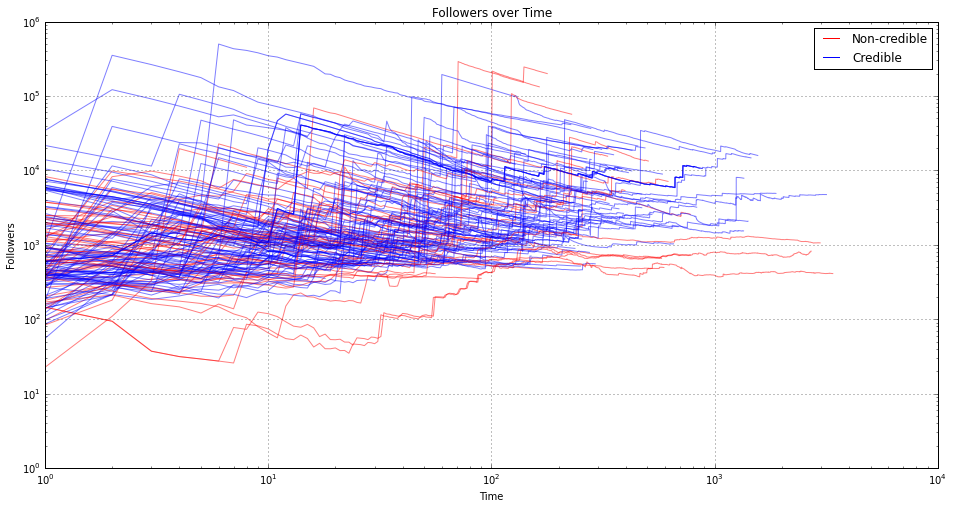

True Avg: 6220.24880952
False Avg: 5841.25133504
T-Test Statistic: 0.142482280906
p-Value: 0.886889014319


In [32]:
plt.figure(figsize=(16,8))

trueData = []
falseData = []

for eventKey in eventMap.keys():
    localEvent = eventMap[eventKey]
    objMap = localEvent["followers"]
    sortedTimes = sorted(objMap.keys())
    
    if ( len(sortedTimes) <= 1 ):
        continue
        
    xData = range(len(sortedTimes))
    yData = map(lambda x: objMap[x], sortedTimes)
    
    (m, b, r, p, err) = linregress(xData, yData)
    medianCount = np.median(yData)
    
    if ( localEvent["truth"] == 0 ):
        plt.loglog (xData, yData, color="r", alpha=0.5)
#         plt.plot(xData, map(lambda x: m*x + b, xData), color="r", alpha=0.5)
        falseData.append(medianCount)
    elif ( localEvent["truth"] == 1 ):
        plt.loglog (xData, yData, color="b", alpha=0.5)
#         plt.plot(xData, map(lambda x: m*x + b, xData), color="b", alpha=0.5)
        trueData.append(medianCount)
    
plt.plot([0], [0], color="r", label="Non-credible")
plt.plot([0], [0], color="b", label="Credible")
plt.xlabel("Time")
plt.ylabel("Followers")
plt.legend()

plt.title("Followers over Time")
plt.grid()
plt.show()

# 0 is very objective, 1 is very subjective
print "True Avg:", np.mean(trueData)
print "False Avg:", np.mean(falseData)

tResStat, tPVal = scipy.stats.ttest_ind(trueData, falseData)

print "T-Test Statistic:", tResStat
print "p-Value:", tPVal

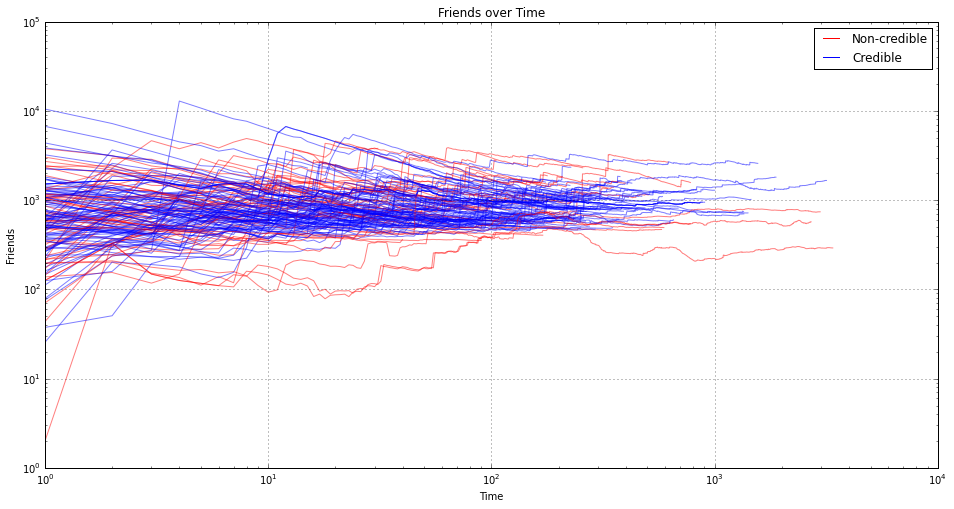

True Avg: 893.575418122
False Avg: 989.44411097
T-Test Statistic: -1.17987417118
p-Value: 0.239905730261


In [33]:
plt.figure(figsize=(16,8))

trueData = []
falseData = []

for eventKey in eventMap.keys():
    localEvent = eventMap[eventKey]
    objMap = localEvent["friends"]
    sortedTimes = sorted(objMap.keys())
    
    if ( len(sortedTimes) <= 1 ):
        continue
        
    xData = range(len(sortedTimes))
    yData = map(lambda x: objMap[x], sortedTimes)
    
    (m, b, r, p, err) = linregress(xData, yData)
    medianCount = np.median(yData)
    
    if ( localEvent["truth"] == 0 ):
        plt.loglog (xData, yData, color="r", alpha=0.5)
#         plt.plot(xData, map(lambda x: m*x + b, xData), color="r", alpha=0.5)
        falseData.append(medianCount)
    elif ( localEvent["truth"] == 1 ):
        plt.loglog (xData, yData, color="b", alpha=0.5)
#         plt.plot(xData, map(lambda x: m*x + b, xData), color="b", alpha=0.5)
        trueData.append(medianCount)
    
plt.plot([0], [0], color="r", label="Non-credible")
plt.plot([0], [0], color="b", label="Credible")
plt.xlabel("Time")
plt.ylabel("Friends")
plt.legend()

plt.title("Friends over Time")
plt.grid()
plt.show()

# 0 is very objective, 1 is very subjective
print "True Avg:", np.mean(trueData)
print "False Avg:", np.mean(falseData)

tResStat, tPVal = scipy.stats.ttest_ind(trueData, falseData)

print "T-Test Statistic:", tResStat
print "p-Value:", tPVal

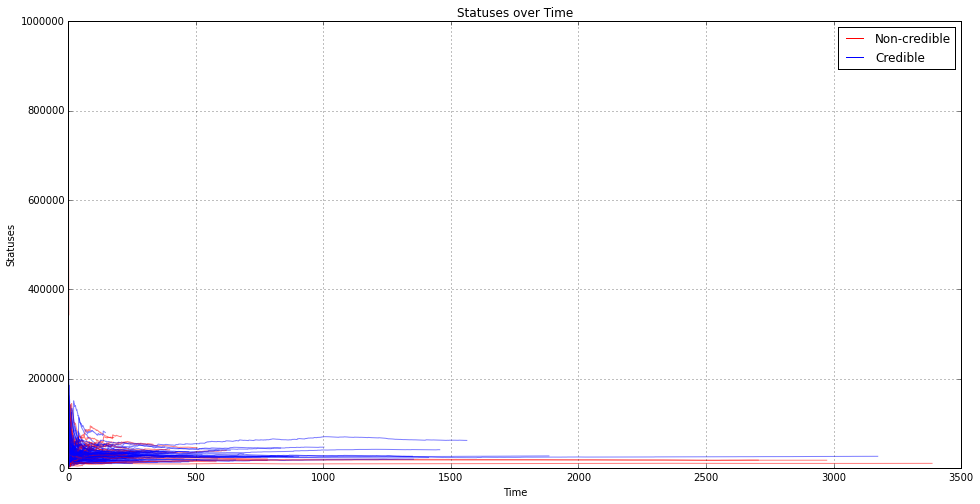

True Avg: 26976.3625464
False Avg: 38220.8098961
T-Test Statistic: -1.67954829061
p-Value: 0.0951131464299


In [34]:
plt.figure(figsize=(16,8))

trueData = []
falseData = []

for eventKey in eventMap.keys():
    localEvent = eventMap[eventKey]
    objMap = localEvent["status_count"]
    sortedTimes = sorted(objMap.keys())
    
    if ( len(sortedTimes) <= 1 ):
        continue
        
    xData = range(len(sortedTimes))
    yData = map(lambda x: objMap[x], sortedTimes)
    
    (m, b, r, p, err) = linregress(xData, yData)
    medianCount = np.median(yData)
    
    if ( localEvent["truth"] == 0 ):
        plt.plot (xData, yData, color="r", alpha=0.5)
#         plt.plot(xData, map(lambda x: m*x + b, xData), color="r", alpha=0.5)
        falseData.append(medianCount)
    elif ( localEvent["truth"] == 1 ):
        plt.plot (xData, yData, color="b", alpha=0.5)
#         plt.plot(xData, map(lambda x: m*x + b, xData), color="b", alpha=0.5)
        trueData.append(medianCount)
    
plt.plot([0], [0], color="r", label="Non-credible")
plt.plot([0], [0], color="b", label="Credible")
plt.xlabel("Time")
plt.ylabel("Statuses")
plt.legend()

plt.title("Statuses over Time")
plt.grid()
plt.show()

# 0 is very objective, 1 is very subjective
print "True Avg:", np.mean(trueData)
print "False Avg:", np.mean(falseData)

tResStat, tPVal = scipy.stats.ttest_ind(trueData, falseData)

print "T-Test Statistic:", tResStat
print "p-Value:", tPVal

## Verified

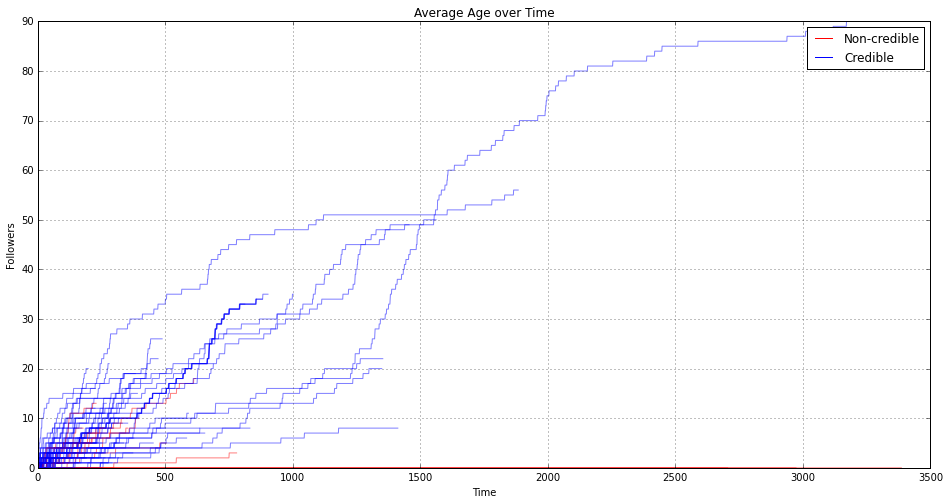

True Avg: 5.61616161616
False Avg: 0.851851851852
T-Test Statistic: 4.01378277572
p-Value: 9.38049192105e-05


In [35]:
for eventKey in eventMap.keys():
    dl = eventMap[eventKey]
    
    sliceVerifiedMap = {}
    
    sortedTimes = sorted(dl["tweets"].keys())
    
    if ( len(sortedTimes) == 0 ):
        print eventKey, "zero entries"
    windowSize = 1
    
    verified = 0
    
    for i in range(0, max(1, len(sortedTimes) - windowSize)):

        
        window = sortedTimes[i:i+windowSize]
        
        for sliceTime in window:
            tweetList = dl["tweets"][sliceTime]
            if ( len(tweetList) == 0 ):
                continue

            for tweet in tweetList:
                user = tweet["user"]
                if ( user["verified"] ):
                    verified += 1
            
        averageVerified = verified

        sliceVerifiedMap[window[0]] = averageVerified

    dl["verified"] = sliceVerifiedMap
            

plt.figure(figsize=(16,8))

trueData = []
falseData = []

for eventKey in eventMap.keys():
    localEvent = eventMap[eventKey]
    objMap = localEvent["verified"]
    sortedTimes = sorted(objMap.keys())
    
    if ( len(sortedTimes) <= 1 ):
        continue
        
    xData = range(len(sortedTimes))
    yData = map(lambda x: objMap[x], sortedTimes)
    
    (m, b, r, p, err) = linregress(xData, yData)
    medianCount = np.median(yData)
    
    if ( localEvent["truth"] == 0 ):
        plt.plot (xData, yData, color="r", alpha=0.5)
#         plt.plot(xData, map(lambda x: m*x + b, xData), color="r", alpha=0.5)
        falseData.append(medianCount)
    elif ( localEvent["truth"] == 1 ):
        plt.plot (xData, yData, color="b", alpha=0.5)
#         plt.plot(xData, map(lambda x: m*x + b, xData), color="b", alpha=0.5)
        trueData.append(medianCount)
    
plt.plot([0], [0], color="r", label="Non-credible")
plt.plot([0], [0], color="b", label="Credible")
plt.xlabel("Time")
plt.ylabel("Followers")
plt.legend()

plt.title("Average Age over Time")
plt.grid()
plt.show()

# 0 is very objective, 1 is very subjective
print "True Avg:", np.mean(trueData)
print "False Avg:", np.mean(falseData)

tResStat, tPVal = scipy.stats.ttest_ind(trueData, falseData)

print "T-Test Statistic:", tResStat
print "p-Value:", tPVal

## Save feature data

In [36]:
dl = eventMap["joshane_event_give-20141214_235644-20141215_010737"]
print dl.keys()

['retweetCount', 'ages', 'mentionCount', 'mediaCount', 'status_count', 'friends', 'polarity', 'verified', 'density', 'urlCount', 'followers', 'truth', 'tweets', 'hashtagCount', 'objectivity', 'tweetCount']


In [37]:
dataMap = {}
for (eventName, eventData) in eventMap.items():
    dataMap[eventName] = {}
    
    featureList = [
        "retweetCount",
        "urlCount",
        "mediaCount",
        "hashtagCount",
        "mentionCount",
        "tweetCount",
        'polarity',
        'verified',
        'status_count',
        'density',
        'ages',
        'followers',
        'objectivity',
        'friends'
    ]
    for k in featureList:
        
        if ( type(eventData[k]) == dict ):
            sortedTimes = sorted(eventData[k].keys())
            yData = map(lambda x: eventData[k][x], sortedTimes)
        
            dataMap[eventName][k] = np.median(yData)
        else:
            dataMap[eventName][k] = eventData[k]
        
    dataMap[eventName]["lifespan"] = len(eventData["tweets"].keys())
    dataMap[eventName]['truth'] = eventData["truth"]

In [38]:
featureFile = codecs.open("credbank_features.json", "w", "utf8")
json.dump(dataMap, featureFile, indent=4)
featureFile.close()

## Learner Test

In [39]:
import sklearn.linear_model
import sklearn.ensemble
import pandas as pd
from sklearn import svm
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold

In [40]:
def mapToFeatures(data):
    df = pd.DataFrame(data.values())
    
    y = df["truth"]
    x = df[filter(lambda x: x != "truth", df.columns)]
    
    return (x.as_matrix(), y.as_matrix())

In [41]:
(xData, yData) = mapToFeatures(dataMap)

print xData.shape

(156, 15)


0
1
2
3
4


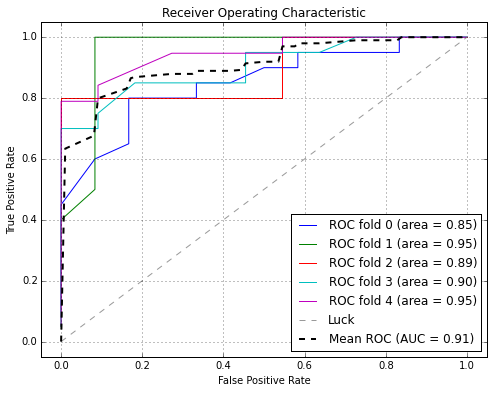

In [43]:
plt.figure(figsize=(8,6))

cv = StratifiedKFold(yData, n_folds=5)

# cls = sklearn.linear_model.LogisticRegression()
# cls = svm.SVC(kernel='linear', probability=True)
cls = sklearn.ensemble.RandomForestClassifier(n_estimators=100)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    print i
    probas_ = cls.fit(xData[train], yData[train]).predict_proba(xData[test])
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(yData[test], probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    
    # Update means
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (AUC = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.savefig("rocauc.pdf", format="pdf")
plt.show()